In [5]:
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(reshape2)
library(plyr)
library(dplyr)
library(Seurat)
library(DescTools)
library(SingleR)
library(viridis)
library(stringr)
library(AUCell)

source("./../sc_analysis_palettes_and_helpers.r")

setwd("./data_and_out/")


## Prepare expression matrix

In [14]:
# Reload Seurat object of clustered NB cells
dat_name <- "allmerged_final"
load(paste0('./../../transcriptome_analysis/data/',dat_name,"_nrblstm_clustered.Robj"))

In [16]:
# Remove remaining cells from control samples
Idents(dat_sub) <- 'sample_id'
dat_sub <- subset(dat_sub, idents = c('EGFP_ctrl_1','LMO1_ctrl_1','LMO1_ctrl_m2'), invert = T)

In [ ]:
# Save a list of all sample names to loop through in the scoring function below
write.csv(unique(as.character(dat_sub$sample_all)), file = 'sample_names_all.csv', quote = F)

### Write subdataset-rds files for scoring

In [ ]:
# Save a separate object for each sample, so that they can be loaded individually by the scoring function.
Idents(dat_sub) <- "sample_id"

for(i in 1:length(unique(dat_sub$sample_all))){

    subname <- unique(dat_sub$sample_all)[i]
    sub <- subset(dat_sub, idents = subname)
    
    saveRDS(sub, file = paste0('NBcells_',subname,'_seurat_obj.rds'))
    
    rm(sub)

}

## Load gene modules

In [45]:
# Load final module table
modules_pan <- read.delim('/local/users/nfresma/repos/neuroblastoma_plasticity/gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]
                             

## Score modules

In [ ]:
# Get list of sample names to loop through
# -> Run the scoring function for cells from each sample separately to reduce RAM intensity
sample_names <- read.delim('sample_names_all.csv',stringsAsFactors = F, header = T, row.names = 1, sep = ',')
sample_names <- sample_names$x

### AUC scores

#### Score

In [ ]:
# Define num_cores to parallelize; check RAM availability before setting this
# Scoring function is provided in sc_analysis_palettes_and_helpers.r

num_cores = 5

enrich_list <- mclapply(sample_names, function(f) {
   
    subname <- f
    sub <- readRDS(paste0('NBcells_',subname,'_seurat_obj.rds'))
        
    sub <- NormalizeData(sub)
    
    if(ncol(sub) < 50){
        return(NULL)
    }else{        
        GeneToEnrichment(srt = sub, db = modules_pan, method = 'auc')
    }
    
}, mc.cores = num_cores)

save(enrich_list, file = paste0('moduleScores_AUC_NBcells_final_modules_',dat_name,'_all_perSample.Robj'))


#### Re-load and plot

In [22]:
# Write Seurat object into a different variable to avoid editing the main object
sub <- dat_sub

In [23]:
# Reload module scores
load(paste0('moduleScores_AUC_NBcells_allDRmods_',dat_name,'_all_perSample.Robj'))
#load(paste0('moduleScores_AUC_NBcells_final_modules_',dat_name,'_all_perSample.Robj'))

In [33]:
# Merge scores for all cells into one dataframe
indtumours <- enrich_list

indtumours_merge <- data.frame()

for(i in 1:length(indtumours)){

    if(is.matrix(indtumours[[i]]) == T){
        indtumours_merge <- rbind(indtumours_merge, indtumours[[i]])
    }else{
        next
    }
}

rm(indtumours)

In [39]:
# Make a column for merging scores with Seurat metadata
indtumours_merge$Barcode <- rownames(indtumours_merge)

sub@meta.data$Barcode <- rownames(sub@meta.data)

table(rownames(indtumours_merge) %in% rownames(sub@meta.data))


  TRUE 
101856 

In [40]:
# merge scores with metadata
metadat_all <- left_join(sub@meta.data, indtumours_merge, by = 'Barcode')
rownames(metadat_all) <- metadat_all$Barcode

In [41]:
# Prepare for adding scores to seurat object
dim(indtumours_merge)
dim(sub@meta.data)

metadat_all <- metadat_all[order(match(rownames(metadat_all), rownames(sub@meta.data))),]
table(rownames(metadat_all) == rownames(sub@meta.data))

[1] 101856     31

[1] 101872     46


  TRUE 
101872 

In [42]:
# If the row names of the object above matched (100 % TRUE), put metadata-object back into Seurat object.
sub@meta.data <- metadat_all

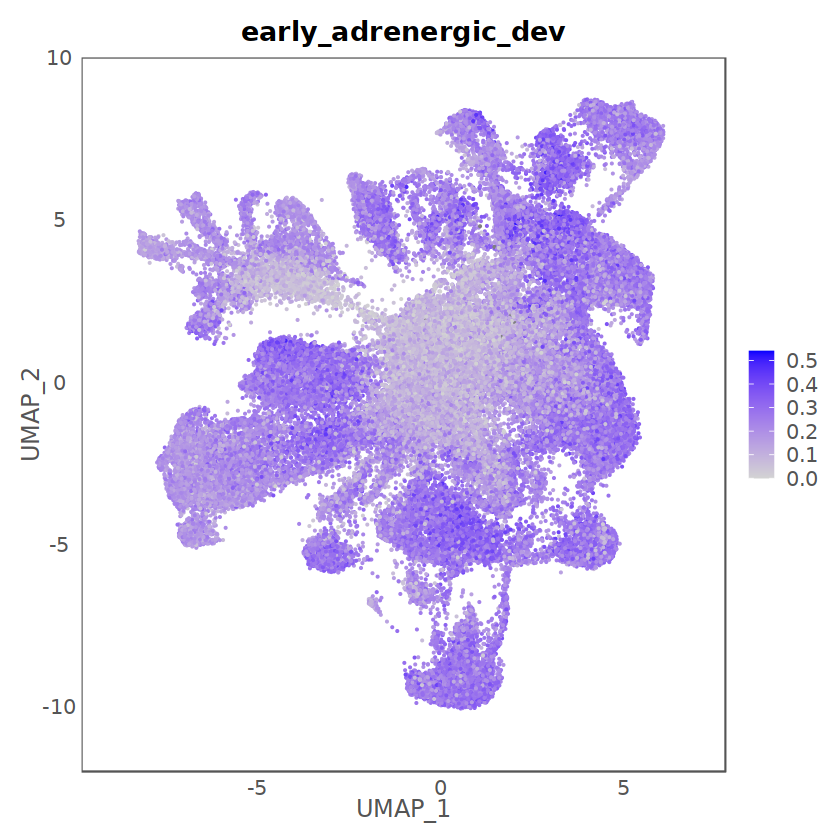

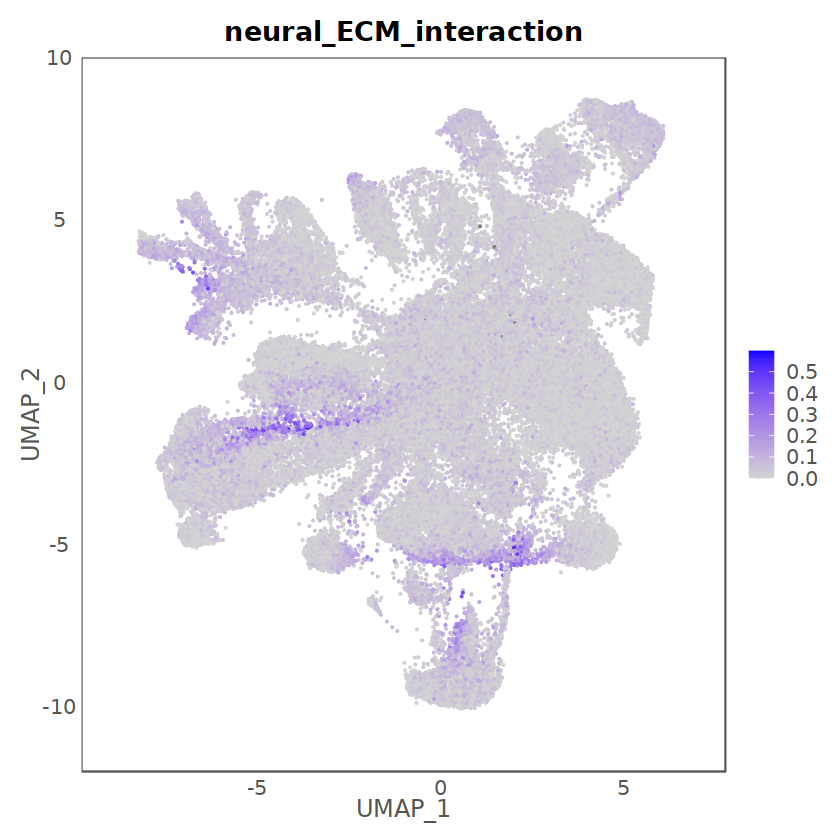

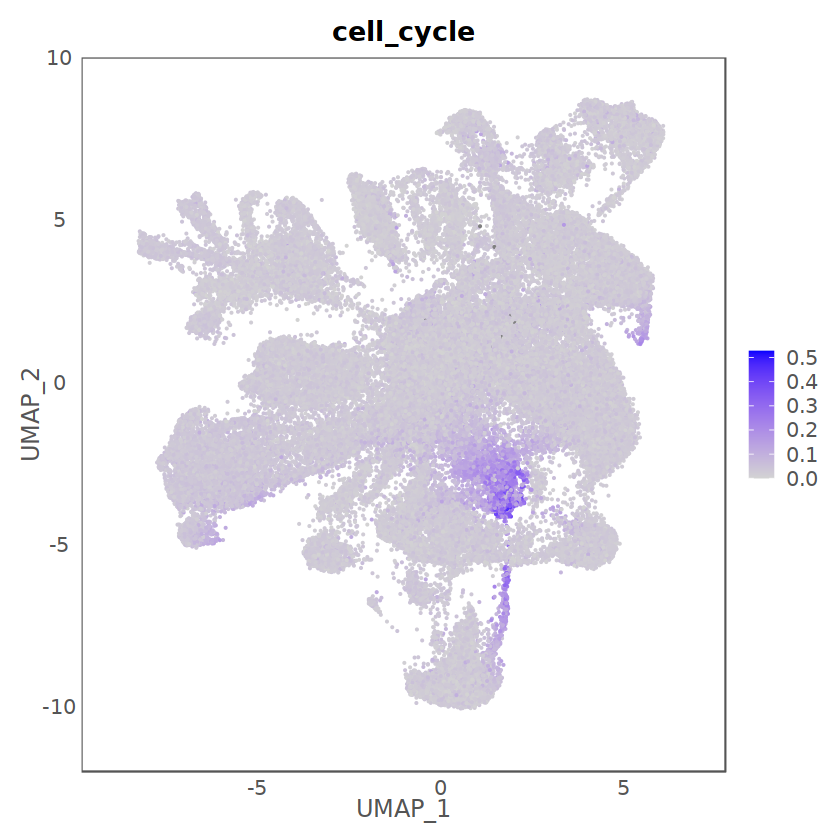

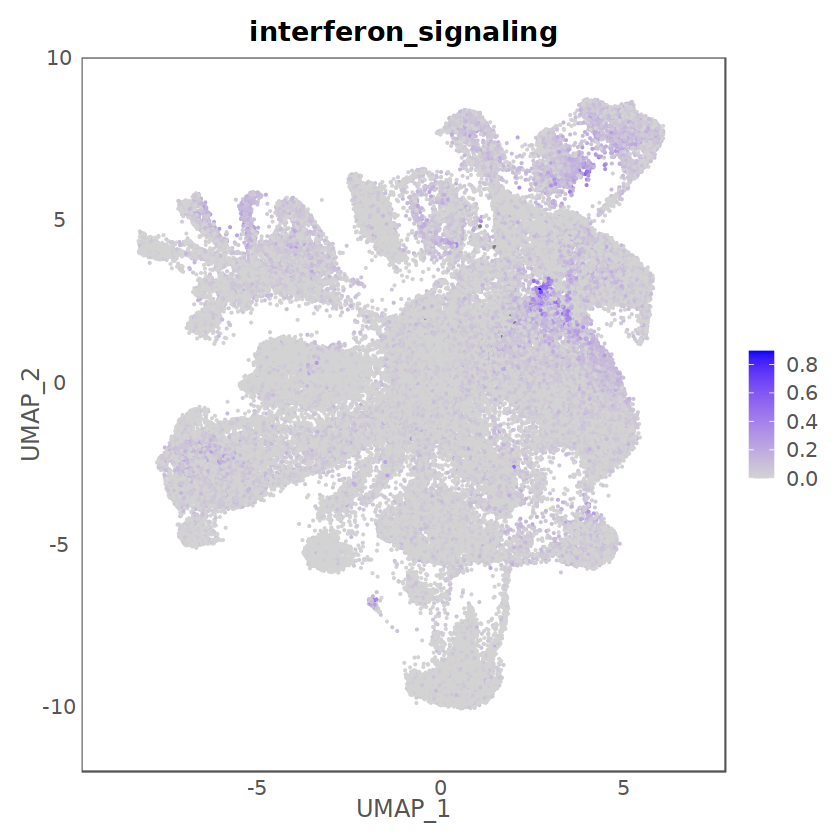

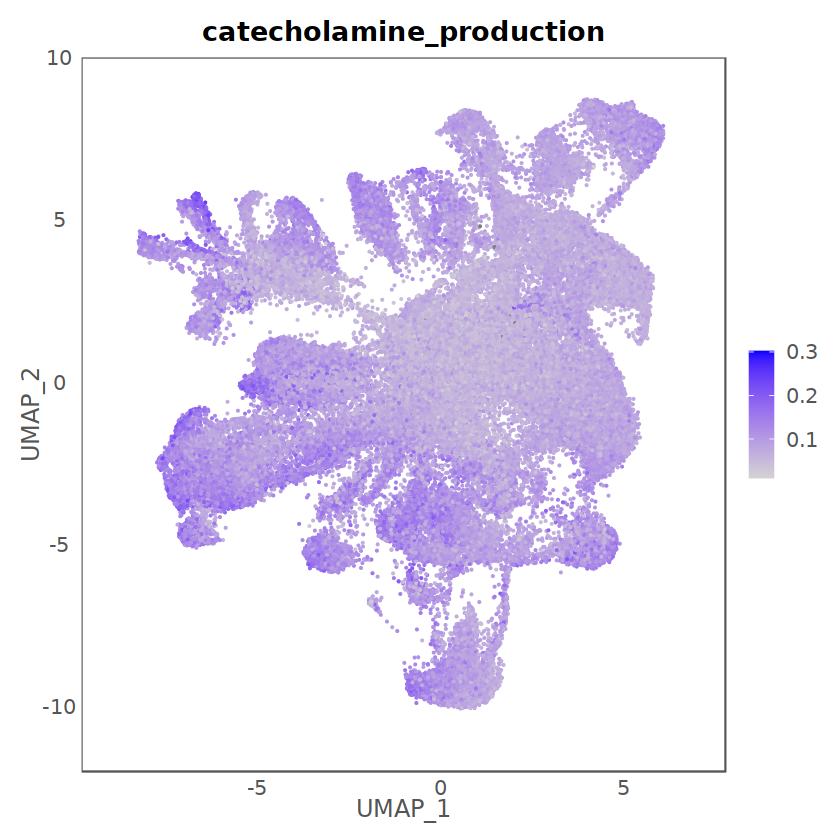

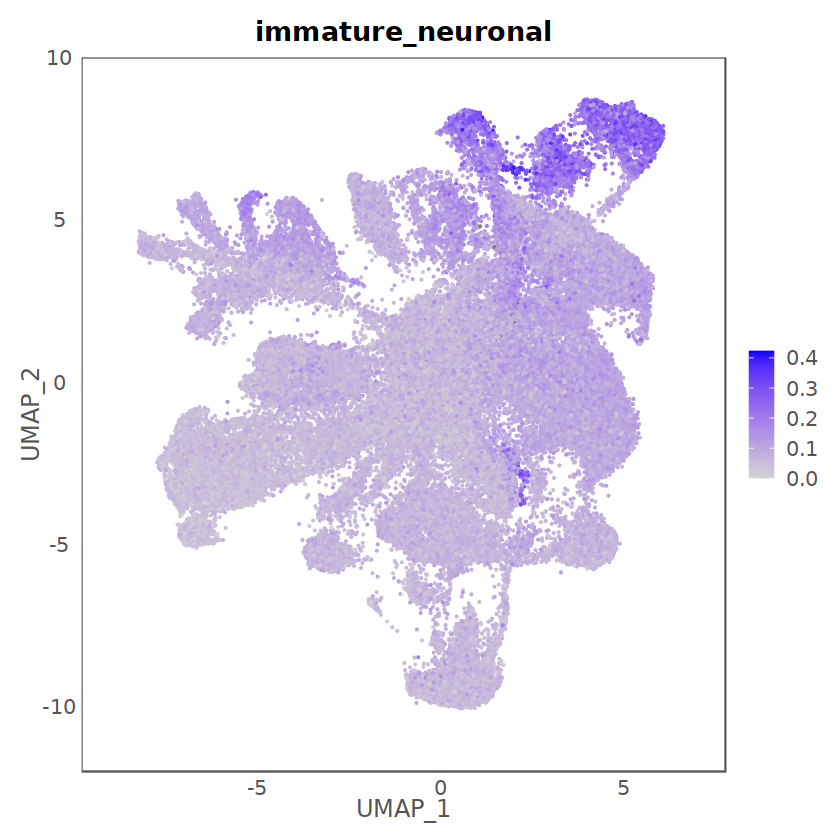

In [47]:
# Plot example score distributions
mods_plot <- names(modules_pan)

#for(i in 1:length(mods_plot)){
for(i in c(1,4,5,7,8,15)){
    print(
        FeaturePlot(sub, features = mods_plot[i], raster=FALSE, pt.size = 0.1) +
            NoAxes() +
            mytheme_angledYtitle
        )
}

### Expression scores between 0 and 1

#### Score

In [ ]:
# Define num_cores to parallelize; check RAM availability before setting this
# Scoring function is provided in sc_analysis_palettes_and_helpers.r

num_cores = 5

enrich_list <- mclapply(sample_names, function(f) {
   
    subname <- f
    sub <- readRDS(paste0('NBcells_',subname,'_seurat_obj.rds'))
        
    sub <- NormalizeData(sub)
    
    if(ncol(sub) < 50){
        return(NULL)
    }else{        
        GeneToEnrichment(srt = sub, db = modules_pan, nbin = 25, nrand = 3, method = 'rand')
    }
    
}, mc.cores = num_cores)

save(enrich_list, file = paste0('moduleScores_Barkley_NBcells_final_modules_',dat_name,'_all_perSample.Robj'))


#### Re-load and plot

In [48]:
# Write Seurat object into a different variable to avoid editing the main object
sub <- dat_sub

In [49]:
# Reload module scores
load(paste0('moduleScores_Barkley_NBcells_final_modules_',dat_name,'_all_perSample.Robj'))

In [50]:
# Merge scores for all cells into one dataframe
indtumours <- enrich_list

indtumours_merge <- data.frame()

for(i in 1:length(indtumours)){

    if(is.matrix(indtumours[[i]]) == T){
        indtumours[[i]] <- t(indtumours[[i]])
        indtumours_merge <- rbind(indtumours_merge, indtumours[[i]])
    }else{
        next
    }
}

rm(indtumours)

In [52]:
# Make a column for merging scores with Seurat metadata
indtumours_merge$Barcode <- rownames(indtumours_merge)

sub@meta.data$Barcode <- rownames(sub@meta.data)

table(rownames(indtumours_merge) %in% rownames(sub@meta.data))


  TRUE 
101856 

In [54]:
# Merge scores with metadata
metadat_all <- left_join(sub@meta.data, indtumours_merge, by = 'Barcode')
rownames(metadat_all) <- metadat_all$Barcode

In [55]:
# Prepare for adding scores to seurat object
metadat_all <- metadat_all[order(match(rownames(metadat_all), rownames(sub@meta.data))),]
table(rownames(metadat_all) == rownames(sub@meta.data))


  TRUE 
101872 

In [56]:
# If the row names of the object above matched (100 % TRUE), put metadata-object back into Seurat object.
sub@meta.data <- metadat_all

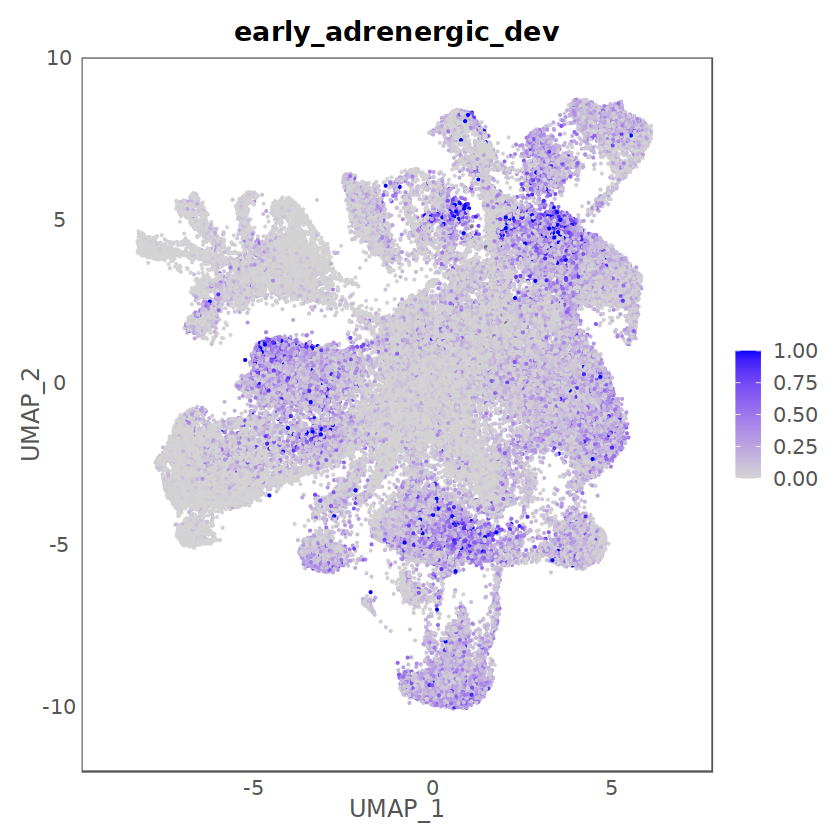

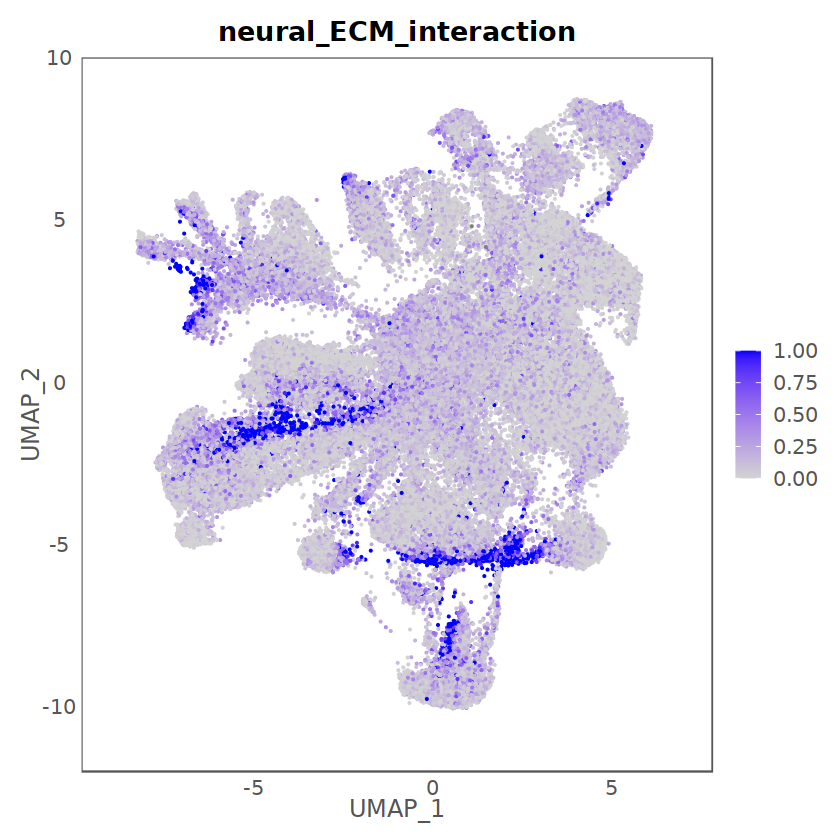

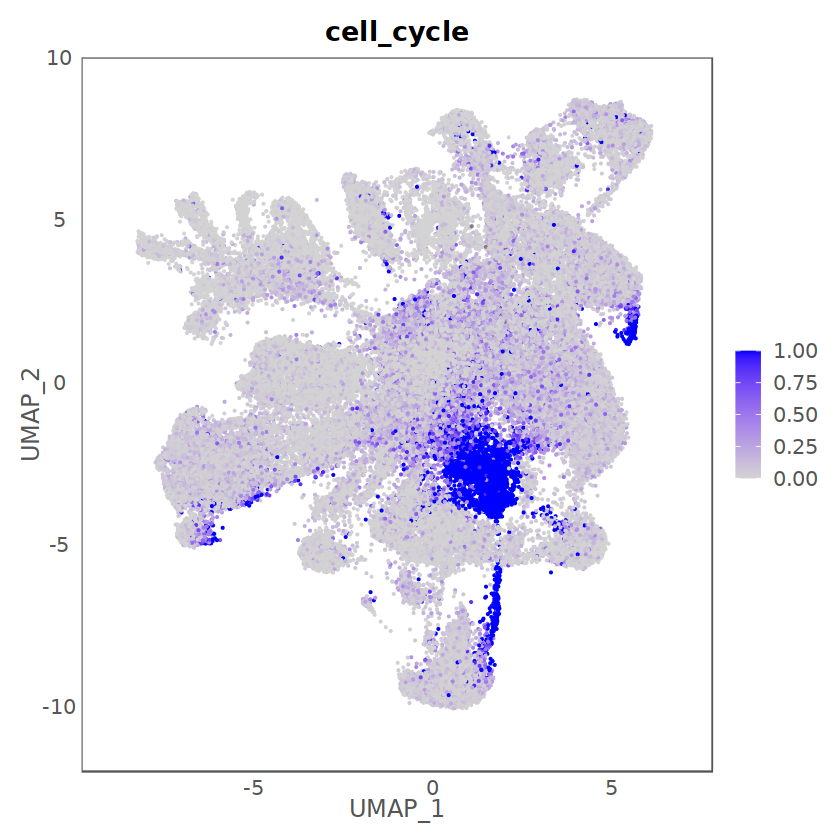

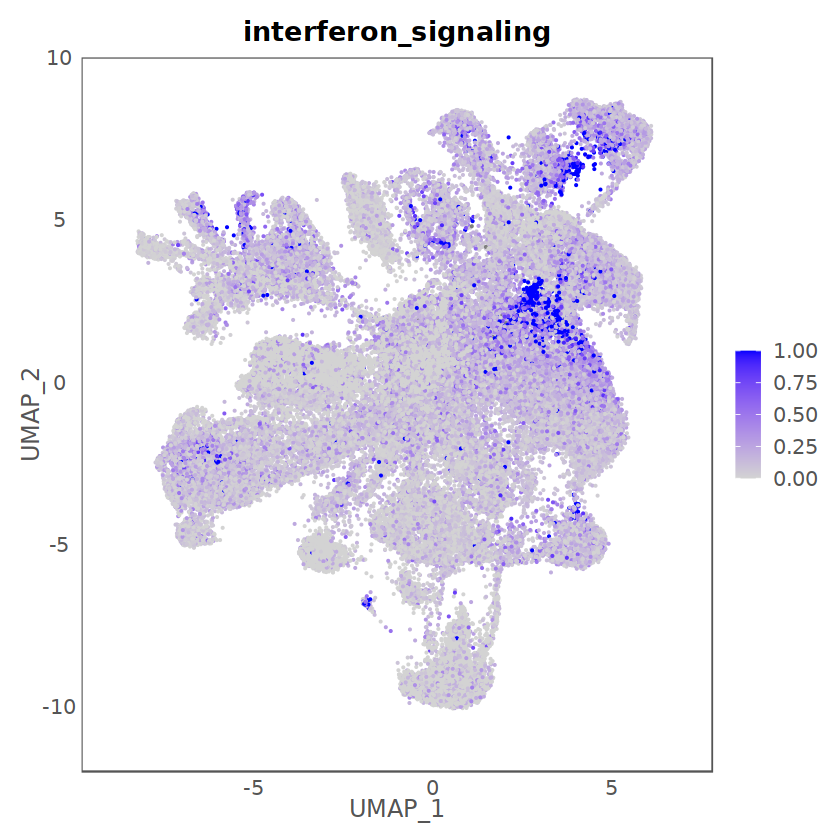

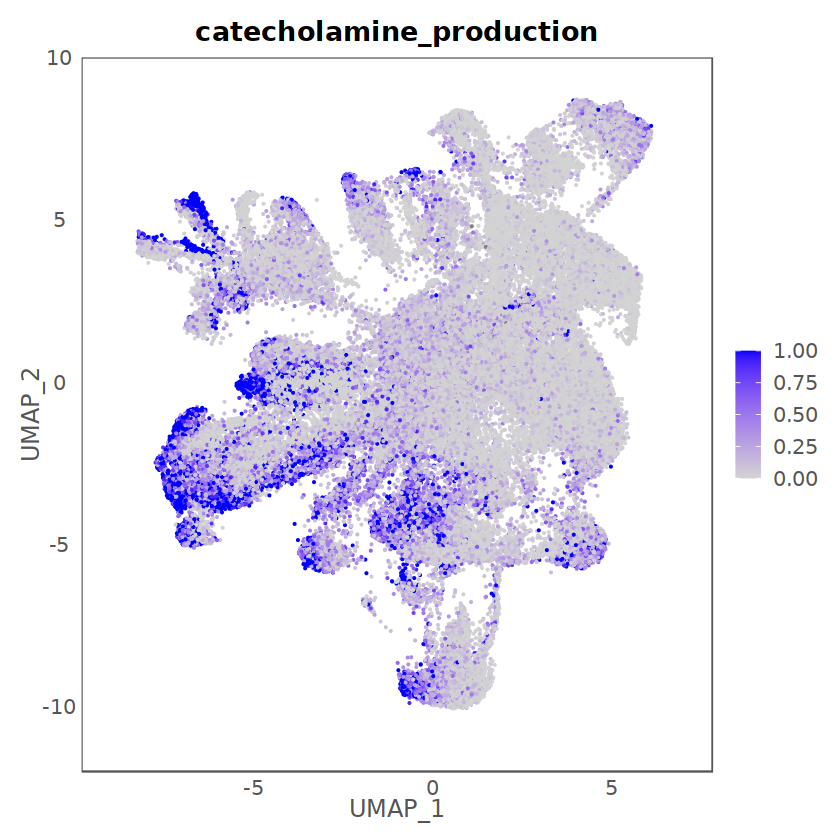

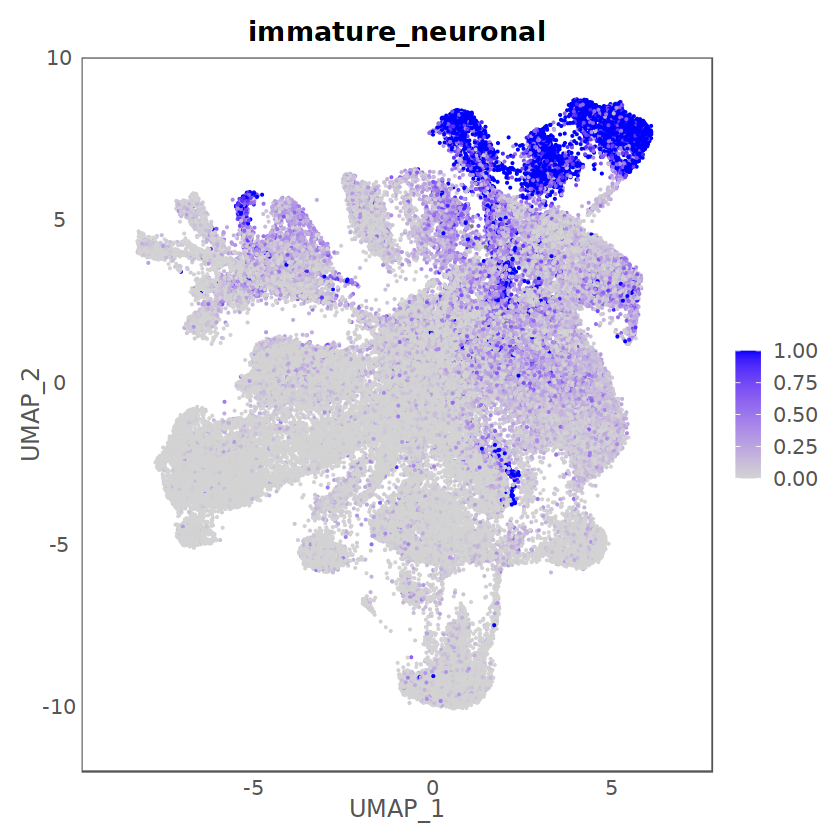

In [58]:
# Plot example score distributions
mods_plot <- names(modules_pan)

#for(i in 1:length(mods_plot)){
for(i in c(1,4,5,7,8,15)){
    print(
        FeaturePlot(sub, features = mods_plot[i], raster=FALSE, pt.size = 0.1) +
            NoAxes() +
            mytheme_angledYtitle
        )
}

#### Calculate and plot fraction of cells expressing module

In [ ]:
# Calculate fraction of cells that express each module

metadat <- sub@meta.data

# save selected metadata (useful for plotting later) per sample
tums <- metadat[duplicated(metadat$sample_id) == F, c("fish_id","tumour_id","genotype","sample_ID","location","sex","diss", "orig.ident","dataset")]


mod_names <- names(modules_pan)

for(l in 1:length(mod_names)){

mod_name <- mod_names[l]

metadat_it <- metadat
names(metadat_it)[names(metadat_it) == mod_name] <- "mod_name"
metadat_it$mod_pres <- "no"
metadat_it$mod_pres[metadat_it$mod_name > 0.5] <- "yes"    

tums$ModFrac <- NA

    for(i in 1:length(unique(tums$sample_all))){

        tum <- unique(tums$sample_all)[i]
        tum_dat <- metadat_it[metadat_it$sample_all == tum,]

        frac_yes <- nrow(tum_dat[tum_dat$mod_pres == "yes",])

        tums$ModFrac[tums$sample_all == tum] <- frac_yes/nrow(tum_dat)
    }
    
names(tums)[names(tums) == 'ModFrac'] <- mod_names[l]
    
}

In [ ]:
write.csv(tums, file = 'fractions_per_sampleAll_final_modules.csv', quote = F)

##### Plot

In [59]:
tums <- read.delim('fractions_per_sampleAll_final_modules.csv',
                   stringsAsFactors = F,
                   sep = ',',
                   row.names = 1, 
                   header = T
                  )

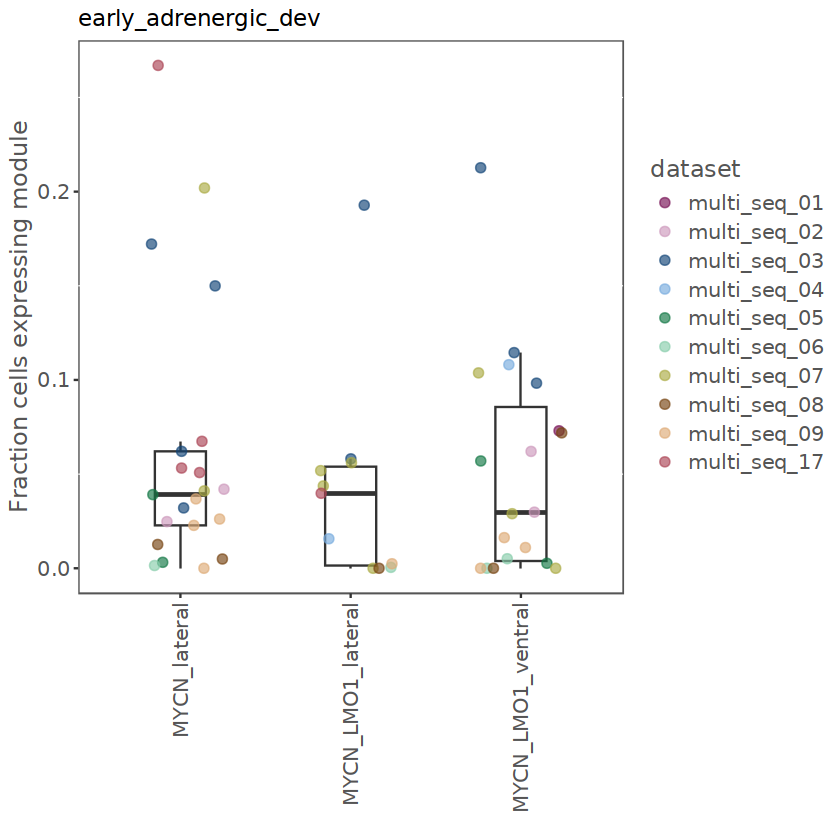

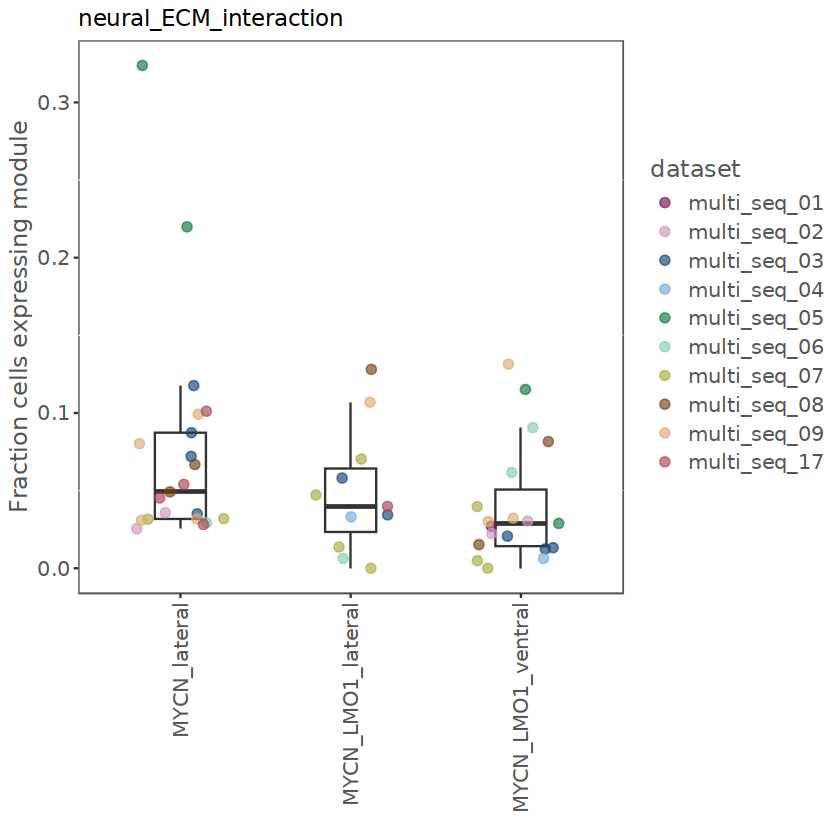

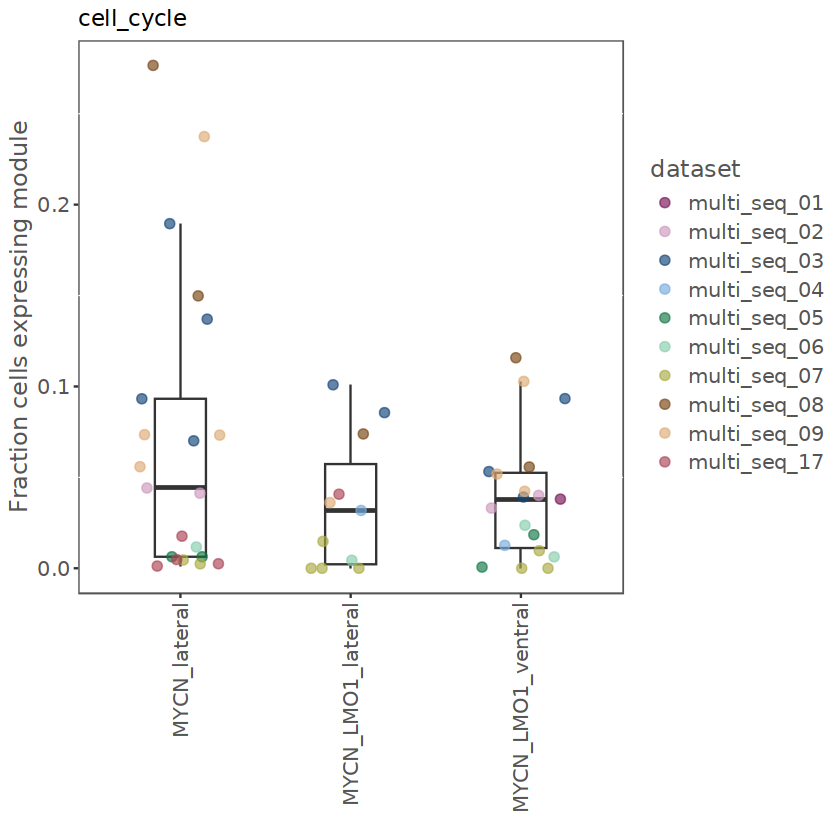

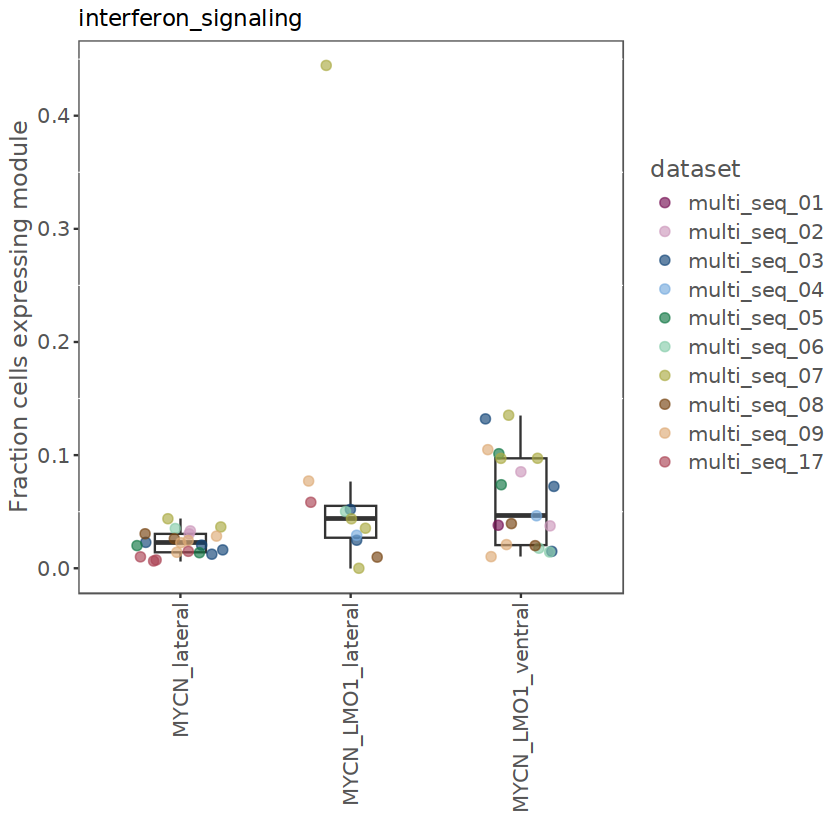

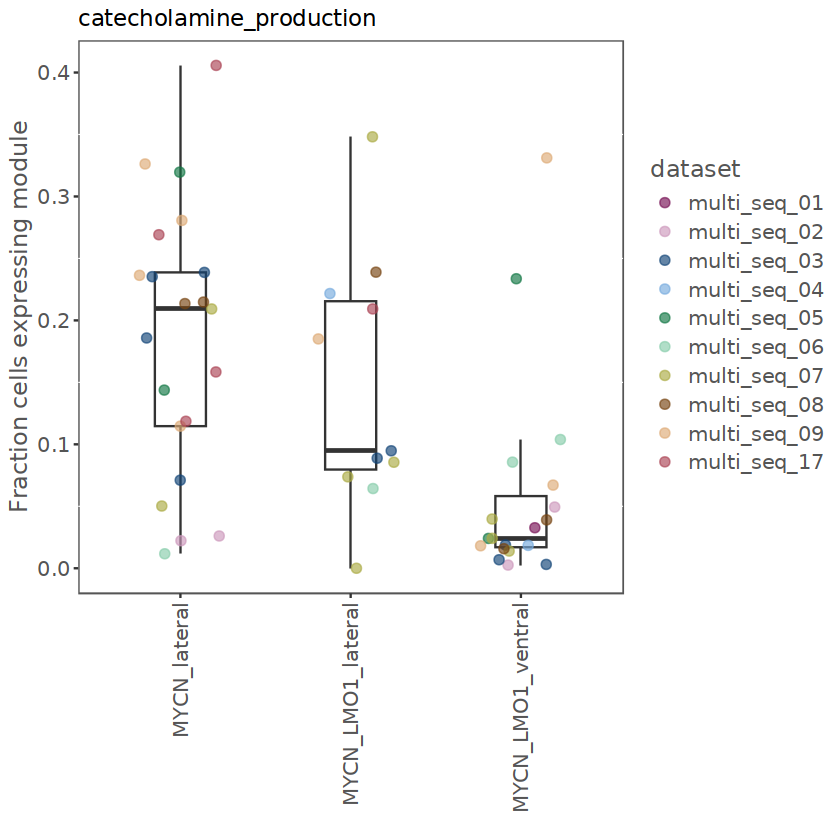

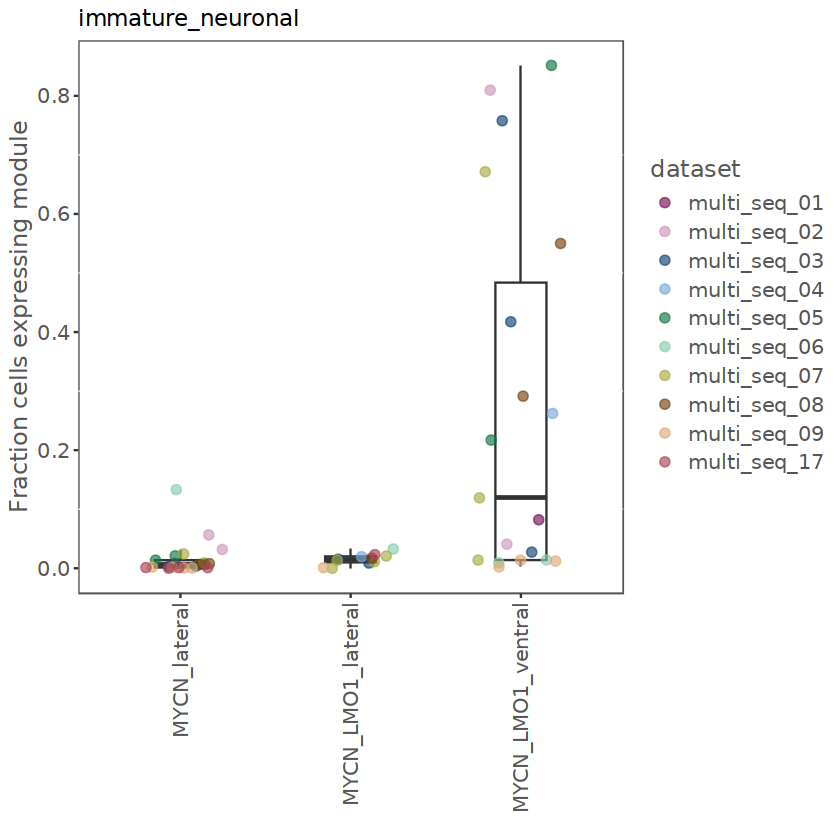

In [61]:
# Only keep tumours of:
# - genotypes MYCN and MYCN/LMO1
# - locations ventral and lateral
# - part of a MULTI-seq dataset

tums <- tums[tums$location %in% c('ventral','lateral'),]
tums <- tums[tums$genotype %in% c('MYCN','MYCN_LMO1'),]
tums <- tums[tums$dataset %like any% 'multi_seq%',]

# Add joint genotype and tumor location meta-column
tums$geno_loc <- paste0(tums$genotype, '_', tums$location)

# Loop through modules and plot
mod_names <- names(modules_pan)

#for(i in 1:length(mod_names)){
for(i in c(1,4,5,7,8,15)){
   
    mod_name <- mod_names[i]

    tums_plot <- tums
    names(tums_plot)[names(tums_plot) == mod_name] <- "mod_it"

    print(
        ggplot(tums_plot, aes(x = geno_loc, y = mod_it)) +
            geom_boxplot(width=0.3, fill = "white", outlier.shape = NA) +
            geom_jitter(width = 0.26,height = 0, alpha = 0.65, size = 2.2, aes(col = dataset)) +
            scale_color_manual(values = tol21rainbow[c(1,3,4,6,10,12,14,16,18,20,22,24,28,26,30,33)]) +
            scale_fill_manual(guide="none") + 
            labs(title = paste0(mod_name), x = '', y = "Fraction cells expressing module") +
            #theme(legend.position = 'none') +
            mytheme_angledX
    )
  
}


### Expression scores: sum of counts

Calculate the sum of counts of all genes in a module. These scores will be used later on to calculate module expression variance.

In [ ]:
# Define num_cores to parallelize; check RAM availability before setting this
# Scoring function is provided in sc_analysis_palettes_and_helpers.r

num_cores = 5

enrich_list <- mclapply(sample_names, function(f) {
   
    subname <- f
    sub <- readRDS(paste0('NBcells_',subname,'_seurat_obj.rds'))
            
    if(ncol(sub) < 50){
        return(NULL)
    }else{        
        GeneToEnrichment(srt = sub, db = modules_pan, method = 'countsum')
    }
    
}, mc.cores = num_cores)

save(enrich_list, file = paste0('moduleScores_CountSum_NBcells_final_modules_',dat_name,'_all_perSample.Robj'))
